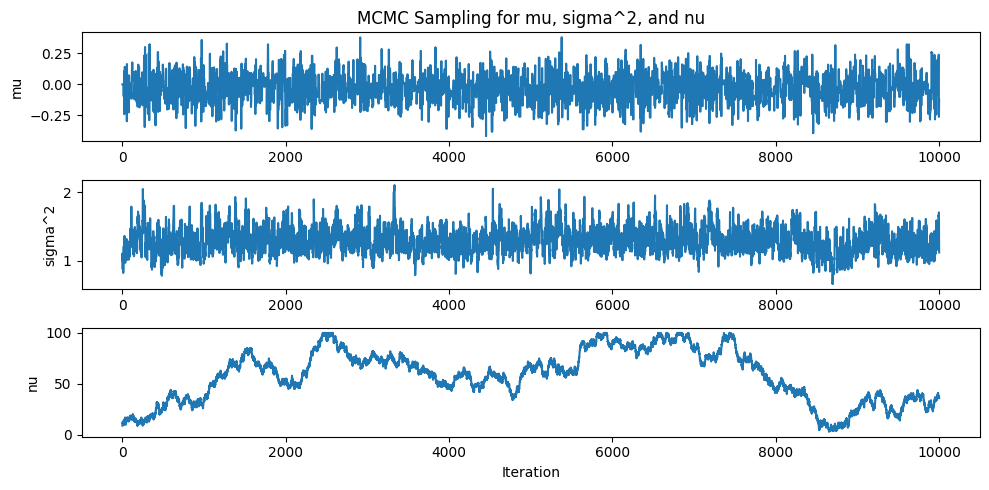

In [7]:
#Q1

import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from scipy.special import gammaln

np.random.seed(50)
n = 100  # Number of samples
true_mu = 0.0
true_sigma2 = 1.0
true_nu = 5
# Generate t-distributed data samples
x = true_mu + np.sqrt(true_sigma2) * stats.t.rvs(df=true_nu, size=n)

# Hyperparameters for the prior distributions
mu0 = 0.0  # Prior mean for mu
tau0 = 1.0  # Precision of the prior for mu
sigma0 = 1.0  # Scale parameter for the half-normal prior on sigma^2

def log_post(mu, sigma2, nu, x, mu0, tau0, sigma0):
    """
    Compute the log posterior probability:
    p(mu, sigma2, nu | x)
    """
    if sigma2 <= 0 or nu < 1 or nu > 100:
        return -np.inf  # Ensure sigma2 > 0 and nu within [1,100]

    # Compute log-likelihood
    ll = np.sum(
        gammaln((nu+1)/2) - gammaln(nu/2) - 0.5*np.log(np.pi*nu*sigma2)
        - ((nu+1)/2)*np.log(1 + ((x-mu)**2)/(nu*sigma2))
    )

    # Compute log prior probabilities
    lp_mu = 0.5*np.log(tau0/(2*np.pi)) - (tau0/2)*(mu - mu0)**2  # Normal prior
    lp_sigma2 = 0.5*np.log(2/(np.pi*sigma0**2)) - (sigma2**2)/(2*sigma0**2)  # Half-normal prior
    lp_nu = -np.log(100)  # Discrete uniform prior

    return ll + lp_mu + lp_sigma2 + lp_nu  # Return total log posterior probability

# MCMC sampling parameters
iters = 10000
mu_samples = np.zeros(iters)
sigma2_samples = np.zeros(iters)
nu_samples = np.zeros(iters, dtype=int)

# Initial values
mu_current = 0.0
sigma2_current = 1.0
nu_current = 10
log_post_current = log_post(mu_current, sigma2_current, nu_current, x, mu0, tau0, sigma0)

# Proposal step sizes
mu_prop_sd = 0.5  # Step size for mu
log_sigma2_prop_sd = 0.1

for t in range(iters):
    # 1. Sample mu (random-walk Metropolis-Hastings)
    mu_proposal = mu_current + np.random.normal(0, mu_prop_sd)
    log_post_proposal = log_post(mu_proposal, sigma2_current, nu_current, x, mu0, tau0, sigma0)
    if np.log(np.random.rand()) < log_post_proposal - log_post_current:
        mu_current = mu_proposal
        log_post_current = log_post_proposal
    mu_samples[t] = mu_current

    # 2. Sample sigma^2 (log-scale Metropolis-Hastings)
    log_sigma2_current = np.log(sigma2_current)
    log_sigma2_proposal = log_sigma2_current + np.random.normal(0, log_sigma2_prop_sd)
    sigma2_proposal = np.exp(log_sigma2_proposal)
    log_post_proposal = log_post(mu_current, sigma2_proposal, nu_current, x, mu0, tau0, sigma0)
    if np.log(np.random.rand()) < log_post_proposal - log_post_current + log_sigma2_proposal - log_sigma2_current:
        sigma2_current = sigma2_proposal
        log_post_current = log_post_proposal
    sigma2_samples[t] = sigma2_current

    # 3. Sample nu (discrete Metropolis update)
    nu_proposal = nu_current + np.random.choice([-1, 1])
    if nu_proposal < 1:
        nu_proposal = 1
    if nu_proposal > 100:
        nu_proposal = 100
    log_post_proposal = log_post(mu_current, sigma2_current, nu_proposal, x, mu0, tau0, sigma0)
    if np.log(np.random.rand()) < log_post_proposal - log_post_current:
        nu_current = nu_proposal
        log_post_current = log_post_proposal
    nu_samples[t] = nu_current

# Visualization of the sampling results
plt.figure(figsize=(10,5))

plt.subplot(3,1,1)
plt.plot(mu_samples)
plt.ylabel("mu")
plt.title("MCMC Sampling for mu, sigma^2, and nu")

plt.subplot(3,1,2)
plt.plot(sigma2_samples)
plt.ylabel("sigma^2")

plt.subplot(3,1,3)
plt.plot(nu_samples)
plt.ylabel("nu")
plt.xlabel("Iteration")

plt.tight_layout()
plt.show()



In [8]:
# Q2

import numpy as np
import pymc as pm
import arviz as az
from scipy import stats

np.random.seed(40)

# Define different sample sizes
sample_sizes = [50, 100, 500, 1000]

# Define true parameter values
true_mu = 0.0
true_sigma = 1.0
true_nu = 5

results = {}

# Iterate through different sample sizes and perform Bayesian modeling
for n in sample_sizes:
    # Generate observed data following a Student-t distribution
    x = true_mu + true_sigma * stats.t.rvs(df=true_nu, size=n)

    # Define the Bayesian model using PyMC
    with pm.Model() as model:
        # Specify prior distributions
        mu = pm.Normal("mu", mu=0, sigma=5)  # Prior for mean
        sigma = pm.HalfNormal("sigma", sigma=1)  # Prior for standard deviation
        nu = pm.DiscreteUniform("nu", lower=1, upper=100)  # Prior for degrees of freedom

        # Model observed data as Student-t distribution
        obs = pm.StudentT("obs", nu=nu, mu=mu, sigma=sigma, observed=x)

        # Perform MCMC sampling
        idata = pm.sample(2000, tune=1000, chains=2, target_accept=0.9, return_inferencedata=True)

    # Store inference results
    results[n] = idata

# Iterate through different sample sizes and summarize the posterior inference for nu
for n in sample_sizes:
    print(f"Sample size: {n}")
    summary = az.summary(results[n], var_names=["nu"])
    print(summary)


Output()

Output()

Output()

Output()

Sample size: 50
      mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
nu  47.008  28.962     3.0     93.0      1.221    0.864     494.0     364.0   

    r_hat  
nu    1.0  
Sample size: 100
      mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
nu  36.513  29.015     2.0     91.0        1.6    1.132     232.0     176.0   

    r_hat  
nu   1.01  
Sample size: 500
     mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
nu  4.954  1.142     3.0      7.0       0.06    0.042     371.0     396.0   

    r_hat  
nu    1.0  
Sample size: 1000
     mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
nu  5.535  0.946     4.0      7.0      0.054    0.038     289.0     369.0   

    r_hat  
nu    1.0  


#Q2
As the sample size increases, the posterior estimation of the degrees of freedom parameter (\($\nu$\)) becomes more stable and approaches the true value (\($\nu$ = 5\)).

In small sample cases (e.g., \(n = 50, 100\)), the mean estimate of \($\nu$\) is **significantly overestimated**, with values around **47.01** for \(n = 50\) and **36.51** for \(n = 100\). The high-density interval (HDI) is extremely wide, spanning from **3 to 93** for \(n = 50\) and **2 to 91** for \(n = 100\), reflecting substantial uncertainty in estimation.

For larger sample sizes (e.g., \(n = 500, 1000\)), the estimation of \(\nu\) becomes more accurate, with posterior means of **4.95** for \(n = 500\) and **5.54** for \(n = 1000\). The HDI also narrows, indicating improved precision. Notably, at \(n = 500\), the posterior mean is already very close to the true value (\($\nu$ = 5\)), and at \(n = 1000\), the estimate remains slightly above 5 but within a reasonable range. The \($\hat{R}$\) diagnostic is **1.0 for all cases**, confirming good MCMC convergence.

Therefore, while larger sample sizes significantly improve the reliability of \($\nu$\) estimation, **\(n = 500\) appears sufficient for a reasonable posterior estimate**. Further increasing the sample size to \(n = 1000\) refines the precision but does not drastically change the inference. This suggests that estimating \($\nu$\) in a Student-t distribution is feasible with moderate sample sizes but requires sufficiently large data to avoid severe overestimation.



### Q3


$
\int_0^{\infty} p(y_i \mid \tau_i) p(\tau_i) d\tau_i = \int_0^{\infty} \sqrt{\frac{\tau_i}{2\pi}} \exp \left( -\frac{1}{2} \tau_i y_i^2 \right) \left( \frac{\nu}{2} \right)^{\nu/2} \frac{\tau_i^{\nu/2 - 1}}{\Gamma (\nu/2)} \exp \left( -\frac{\nu}{2} \tau_i \right) d\tau_i$

By simplifying the powers of \($\tau_i$\):

\$
\sqrt{\tau_i} \tau_i^{\nu/2 -1} = \tau_i^{\frac{1}{2} + \frac{\nu}{2} -1} = \tau_i^{\frac{\nu - 1}{2}}$


Thus, the integrand becomes:

\$
\frac{1}{\sqrt{2\pi}} \left(\frac{\nu}{2}\right)^{\nu/2} \frac{\tau_i^{\frac{\nu-1}{2}}}{\Gamma (\nu/2)} \exp \left( -\frac{1}{2} \tau_i (y_i^2 + \nu) \right)$


This expression resembles the kernel of a Gamma distribution with parameters:

- **Shape parameter**: \( a = $\frac{\nu + 1}{2}$ \)
- **Rate parameter**: \( b = $\frac{y_i^2 + \nu}{2} $\)

Since the integral of a Gamma density is:

\$
\int_0^{\infty} \tau_i^{a-1} e^{-b \tau_i} d\tau_i = \frac{\Gamma(a)}{b^a}$


then obtain:

$
\int_0^{\infty} p(y_i \mid \tau_i) p(\tau_i) d\tau_i = \frac{1}{\sqrt{2\pi}} \left(\frac{\nu}{2}\right)^{\nu/2} \frac{\Gamma \left( \frac{\nu+1}{2} \right)}{\Gamma \left(\nu/2\right)} \left( \frac{y_i^2 + \nu}{2} \right)^{-(\nu+1)/2}$


Rearranging terms:

$
\frac{1}{\sqrt{2\pi}} \frac{1}{\left( \frac{y_i^2 + \nu}{2} \right)^{1/2}} = \frac{1}{\sqrt{\pi (y_i^2 + \nu)}}$


Also noting:

$
\left(\frac{\nu}{2} \right)^{\nu/2} \left( \frac{2}{y_i^2 + \nu} \right)^{(\nu+1)/2} = \left( \frac{\nu}{y_i^2 + \nu} \right)^{\nu/2} \left( \frac{2}{y_i^2 + \nu} \right)^{1/2}$

Thus, can derive:

$
\int_0^{\infty} p(y_i \mid \tau_i) p(\tau_i) d\tau_i = \frac{\Gamma \left(\frac{\nu+1}{2} \right)}{\sqrt{\pi (y_i^2 + \nu)} \Gamma (\nu/2)} \left(\frac{\nu}{y_i^2 + \nu} \right)^{\nu/2}$

Writing:

$
\sqrt{\pi (y_i^2 + \nu)} = \sqrt{\nu \pi} \sqrt{1 + \frac{y_i^2}{\nu}}, \quad \left(\frac{\nu}{y_i^2 + \nu} \right)^{\nu/2} = \left( 1 + \frac{y_i^2}{\nu} \right)^{-\nu/2}$

So arrive at:

$
p(y_i) = \frac{\Gamma \left(\frac{\nu+1}{2} \right)}{\sqrt{\nu\pi} \Gamma (\nu/2)} \left( 1 + \frac{y_i^2}{\nu} \right)^{-\frac{\nu+1}{2}}$

This is exactly the probability density function of a Student's t-distribution with:

- Degrees of freedom: \( $\nu$ \)
- Location: \( 0 \)
- Scale: \( 1 \)

### **Interpretation**
This derivation shows that **integrating out the latent precision parameter \( $\tau_i$ \) (which follows a Gamma prior) leads to a marginal distribution for \( y_i \) that follows a Student's t-distribution. This is analogous to hierarchical Bayesian models, where marginalizing over latent variables introduces heavier tails compared to a normal distribution. The heavier tails reflect increased uncertainty, making the t-distribution more robust to outliers than the normal distribution.
